<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/JetTagging_2DCNN_TFKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks for Jet-Images
Author: Javier Duarte, Thong Nguyen                            
Modified: Andre Sznajder

In [ ]:
#!fusermount -u drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

Mounted at /content/gdrive


## Load numpy arrays
Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

In [ ]:
import h5py

h5f = h5py.File(data_dir+"jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict['QCD'] = h5f['QCD'][()]
jet_images_dict['TT'] = h5f['TT'][()]

h5f.close()

In [ ]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict['QCD'].shape)
print(jet_images_dict['TT'].shape)

(3305, 30, 30, 1)
(1821, 30, 30, 1)


## Plotting jet-images
Let's plot some jet-images (individual jets and averaged over all jets)

**Question 1:**  Try to plot the average W and QCD jet-images.

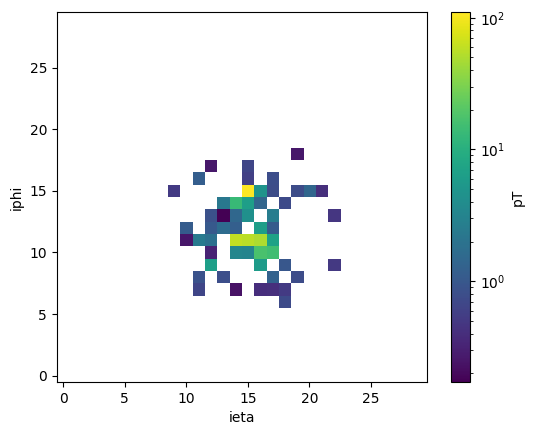

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
plt.style.use('default')

# plot one W jet
i = 7
plt.figure('W') 
plt.imshow(jet_images_dict['TT'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average W jet

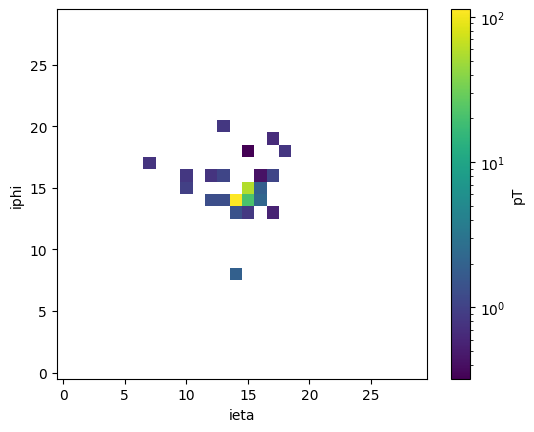

In [ ]:
# plot one QCD jet
i = 7
plt.figure() 
plt.imshow(jet_images_dict['QCD'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average QCD jet

## Define our convolutional model
**Question 2:** Here we have a relatively simple `Conv2D` model using regularization, batch normalization, max pooling, and a fully connected layer before the ouput. Implement the network defined in https://arxiv.org/pdf/1511.05190.pdf. Compare the performance and number of parameters when using fully connected layers instead of convolutional layers.

In [ ]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from keras.regularizers import l1,l2
nx = 30
ny = 30
inputs = Input(shape=(nx, ny, 1), name='input')
h = Conv2D(8, (3, 3), 
           strides=(1, 1), 
           padding='same', 
           activation='relu', 
           name='conv2d_1', 
           kernel_regularizer=l2(0.01))(inputs)
h = Conv2D(2, (3, 3), 
           strides=(1, 1), 
           padding='same', 
           activation='relu', 
           name='conv2d_2', 
           kernel_regularizer=l2(0.01))(h)           
h = BatchNormalization(momentum=0.6, name='batchnorm_1')(h)
h = MaxPool2D(pool_size=(2, 2), name='maxpool2d_1')(h)
h = Flatten(name='flatten')(h)
h = Dense(64, activation='relu', name='dense1')(h)
h = Dense(16, activation='relu', name='dense2')(h)
outputs = Dense(1, activation='sigmoid', name='output')(h)
cnn = Model(inputs=inputs, outputs=outputs)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 30, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 2)         146       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 30, 30, 2)         8         
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 15, 15, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 450)               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                28864 

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) and use early stoppping regularization.


In [ ]:
jet_images = np.concatenate([jet_images_dict['TT'],
                             jet_images_dict['QCD']])
jet_labels = np.concatenate([np.ones(len(jet_images_dict['TT'])), 
                             np.zeros(len(jet_images_dict['QCD']))])

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
#X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7, shuffle=True)

print('number of W jets for training/validation: %i'%np.sum(Y_train_val==1))
print('number of QCD jets for training/validation: %i'%np.sum(Y_train_val==0))

print('number of W jets for testing: %i'%np.sum(Y_test==1))
print('number of QCD jets for testing: %i'%np.sum(Y_test==0))

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into conv2d_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('conv2d_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

number of W jets for training/validation: 1459
number of QCD jets for training/validation: 2641
number of W jets for testing: 362
number of QCD jets for testing: 664


## Run training
Here, we run the training.

In [ ]:
# Train classifier
history = cnn.fit(X_train_val, Y_train_val, 
                    epochs=100, 
                    batch_size=1024, 
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)
                    
#                     callbacks=[early_stopping, model_checkpoint], 
                    

Epoch 1/100
4/4 [==============================] - 3s 688ms/step - loss: 0.6879 - acc: 0.6680 - val_loss: 0.5802 - val_acc: 0.7737
Epoch 2/100
4/4 [==============================] - 2s 551ms/step - loss: 0.5442 - acc: 0.7875 - val_loss: 0.4932 - val_acc: 0.8293
Epoch 3/100
4/4 [==============================] - 2s 545ms/step - loss: 0.4937 - acc: 0.8546 - val_loss: 0.4675 - val_acc: 0.8732
Epoch 4/100
4/4 [==============================] - 2s 545ms/step - loss: 0.4741 - acc: 0.8750 - val_loss: 0.4223 - val_acc: 0.8693
Epoch 5/100
4/4 [==============================] - 2s 543ms/step - loss: 0.4211 - acc: 0.8798 - val_loss: 0.4018 - val_acc: 0.8654
Epoch 6/100
4/4 [==============================] - 2s 547ms/step - loss: 0.3876 - acc: 0.8713 - val_loss: 0.3877 - val_acc: 0.8693
Epoch 7/100
4/4 [==============================] - 2s 542ms/step - loss: 0.3684 - acc: 0.8758 - val_loss: 0.3706 - val_acc: 0.8732
Epoch 8/100
4/4 [==============================] - 2s 554ms/step - loss: 0.3482 - a

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

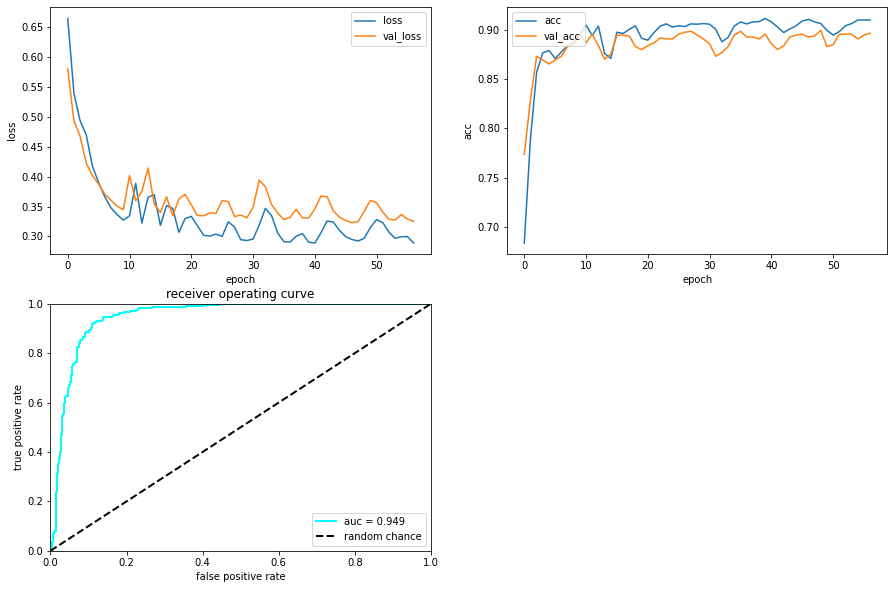

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#
# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = cnn.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

In [ ]:
# Plot DNN output 
df_sig  = df['sig'].filter(NN_VARS)
df_bkg  = df['bkg'].filter(NN_VARS)

X_sig  = np.asarray( df_sig.values ).astype(np.float32)
X_bkg  = np.asarray( df_bkg.values ).astype(np.float32)

Y_sig = model.predict(X_sig)
Y_bkg = model.predict(X_bkg)

ax = plt.subplot(3, 2, 4)
X = np.linspace(0.0, 1.0, 100)
hist_sig = ax.hist(Y_sig, bins=X, label='sig',histtype='step',lw=LINE_WIDTH)
hist_bkg = ax.hist(Y_bkg, bins=X, label='bkg',histtype='step',lw=LINE_WIDTH)
#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})


# Plot Eff x Purity

ax = plt.subplot(3, 2, 5)
ax.plot(t, p[:-1], label='purity', lw=LINE_WIDTH)
ax.plot(t, r[:-1], label='efficiency', lw=LINE_WIDTH)
ax.set_xlabel('Cut on model score')
ax.tick_params(width=2, grid_alpha=0.5)
ax.legend()

ax = plt.subplot(3, 2, 6)
ax.plot(t,p[:-1]*r[:-1], lw=LINE_WIDTH)
ax.set_xlabel('Cut on model score')
ax.set_ylabel('Purity*Efficiency')
ax.tick_params(width=2, grid_alpha=0.5)

# Show plots
plt.show()

NameError: ignored